### Training

In [17]:
import importlib

import utils.sound_utils as su
import utils.train_utils as tu
import utils.filter_utils as filter
import utils.plot_utils as pu
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import wget
import copy
import os
import sys
import importlib
import pickle
import scipy
import numpy as np
import pandas as pd
from collections import namedtuple

importlib.reload(su)
importlib.reload(tu)
importlib.reload(pu)
importlib.reload(filter)


<module 'utils.filter_utils' from 'c:\\Users\\gonza\\OneDrive\\Documentos\\Gonzalo\\Especializacion\\inteligencia_embebida\\esp32_loopback\\python\\utils\\filter_utils.py'>

In [82]:
class_labels = {
    0: "bite",
    1: "chew",
    2: "chew_byte"
}

#### Dataset analysis

In [4]:
train_labels = pd.read_csv("data/train_labels.csv")
test_labels = pd.read_csv("data/test_files.csv")

In [5]:
train_labels.head()

,filename,pasture,height,label
0,4,alfalfa,tall,2
1,9,alfalfa,tall,2
2,10,alfalfa,tall,1
3,11,alfalfa,tall,2
4,13,alfalfa,tall,2


In [6]:
test_labels.head()

,filename
0,1
1,2
2,3
3,5
4,6


In [7]:
dataset = tu.upload_dataset("data/audios")

In [10]:
len(dataset[0][1])

17640

#### Upload dataset

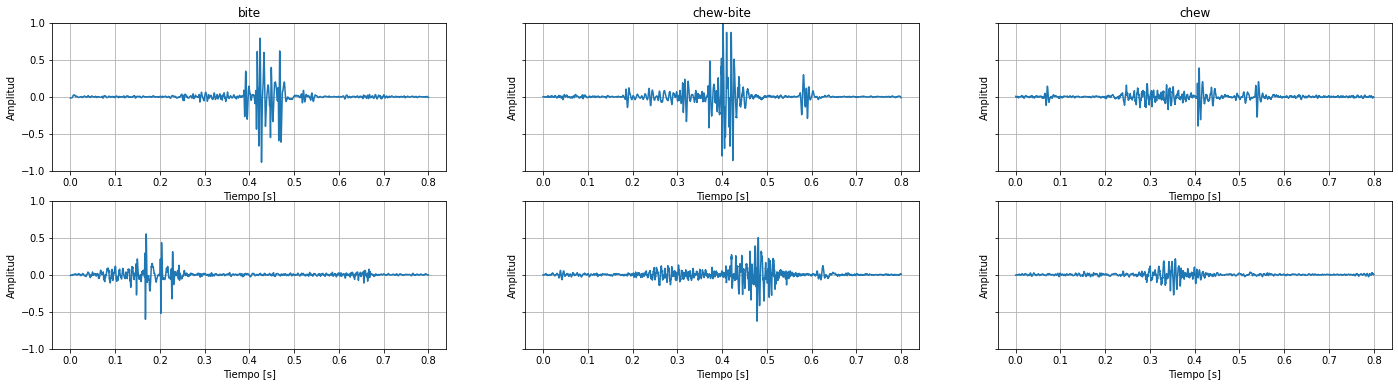

In [25]:

dataset = su.AudioDataset("./data/audios", "./data/train_labels.csv")

def plot_audio_data(my_dataset):
    t = np.arange(0, len(my_dataset[24].data) / my_dataset[24].sample_freq, 1 / my_dataset[24].sample_freq)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 6), sharey=True)
    axes[0, 0].set_ylim((-1, 1))
    axes[0, 1].set_ylim((-1, 1))

    axes[0, 0].set_title("bite")
    axes[0, 0].plot(t, my_dataset[24].data)
    axes[0, 0].set_xlabel('Tiempo [s]')
    axes[0, 0].set_ylabel('Amplitud')
    axes[0, 0].grid(True)

    axes[1, 0].plot(t, my_dataset[48].data)
    axes[1, 0].set_xlabel('Tiempo [s]')
    axes[1, 0].set_ylabel('Amplitud')
    axes[1, 0].grid(True)

    axes[0, 1].set_title("chew-bite")
    axes[0, 1].plot(t, my_dataset[0].data)
    axes[0, 1].set_xlabel('Tiempo [s]')
    axes[0, 1].set_ylabel('Amplitud')
    axes[0, 1].grid(True)

    axes[1, 1].plot(t, my_dataset[1].data)
    axes[1, 1].set_xlabel('Tiempo [s]')
    axes[1, 1].set_ylabel('Amplitud')
    axes[1, 1].grid(True)

    axes[0, 2].set_title("chew")
    axes[0, 2].plot(t, my_dataset[2].data)
    axes[0, 2].set_xlabel('Tiempo [s]')
    axes[0, 2].set_ylabel('Amplitud')
    axes[0, 2].grid(True)

    axes[1, 2].plot(t, my_dataset[8].data)
    axes[1, 2].set_xlabel('Tiempo [s]')
    axes[1, 2].set_ylabel('Amplitud')
    axes[1, 2].grid(True)

plot_audio_data(dataset)

In [12]:
filtered_data = []

sample_rate = 22050
f_cutoff = 5
f_norm = f_cutoff / sample_rate
window_size = (0.196202 + f_norm ** 2) ** 0.5 / f_norm

filter_ma = filter.MovingAverage(window_size=int(window_size))

for value in dataset[0].data:
    absolute = abs(value) if abs(value) >= 0 else np.iinfo(value.dtype).max
    filtered_data.append(filter_ma.calculate_ma(absolute))

In [14]:
filtered_data = []

sample_rate = 22050
f_cutoff = 5
f_norm = f_cutoff / sample_rate
window_size = (0.196202 + f_norm ** 2) ** 0.5 / f_norm

filter_ma = filter.MovingAverage(window_size=int(window_size))

for i, audio in enumerate(dataset):

    if i % 100 == 0:
        print(f"Iteration {i}")

    filtered_aux = []
    for value in audio.data:
        absolute = abs(value) if abs(value) >= 0 else np.iinfo(value.dtype).max
        filtered_aux.append(filter_ma.calculate_ma(absolute))
    filtered_data.append(filtered_aux)
    
    

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500


In [15]:
with open('data/filtered_data.pkl', 'wb') as f:
    pickle.dump(filtered_data, f)

In [29]:
min(filtered_data[24])

0.0038453790734064713

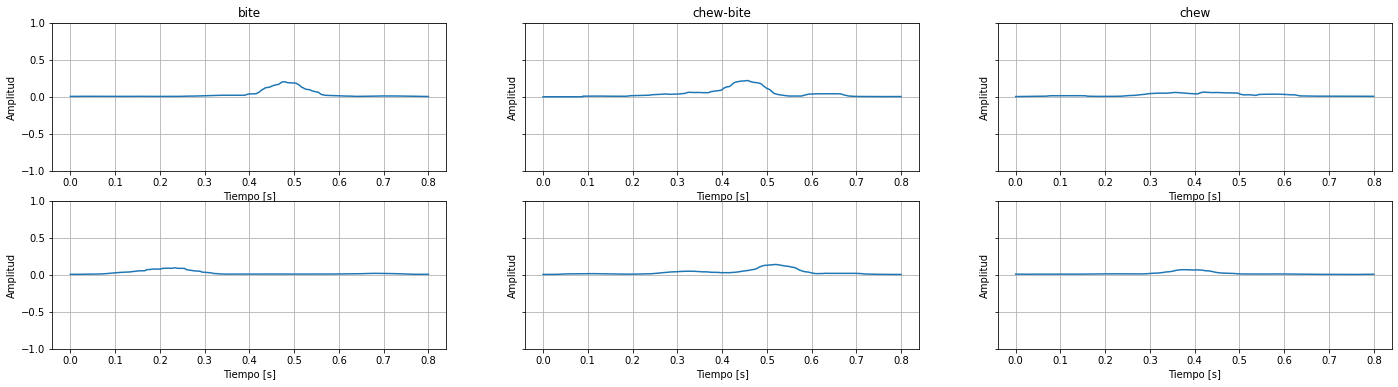

In [39]:
from dataclasses import dataclass

@dataclass
class Data:
    data: list
    label: int
    sample_freq: int

filtered_dataset = []

for i, data in enumerate(filtered_data):
    filtered_dataset.append(Data(data, dataset[i].label, dataset[i].sample_freq))

plot_audio_data(filtered_dataset)

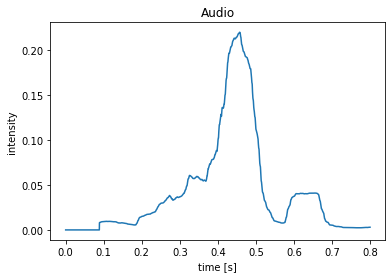

In [41]:
from utils.sound_utils import plot_audio

plot_audio(filtered_dataset[0].data, sample_rate)

In [43]:
noise_gate_data = []
noise_gate = su.NoiseGate(open_threshold=0.05, close_threshold=0.05, hold=0.05)
for data in filtered_dataset:
    filtered_data_list, init, end = noise_gate.split(data.data, sample_rate)
    if len(filtered_data_list) == 1:
        noise_gate_data.append(filtered_data_list[0])
    elif len(filtered_data_list) > 0:
        noise_gate_data.append(filtered_data_list[0])
    else:
        noise_gate_data.append([])

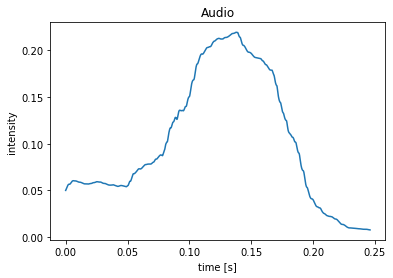

In [44]:
plot_audio(noise_gate_data[0], sample_rate)

In [49]:
extracted_data = []
for data in noise_gate_data:
    extractor = su.FeatureExtractor(data, sample_rate)
    extracted_data.append(extractor.extract_features())

extracted_dataset = []
for i, data in enumerate(extracted_data):
    extracted_dataset.append(Data(data, dataset[i].label, dataset[i].sample_freq))

In [46]:
with open('data/extracted_data.pkl', 'wb') as f:
    pickle.dump(extracted_data, f)

In [43]:
file = open('data/extracted_data.pkl', 'rb')
extracted_data = pickle.load(file)

In [50]:
extracted_dataset[0].data

[0.24603174603174602,
 0.21932469836094298,
 162,
 0.6045626238392092,
 0.06896682941364539]

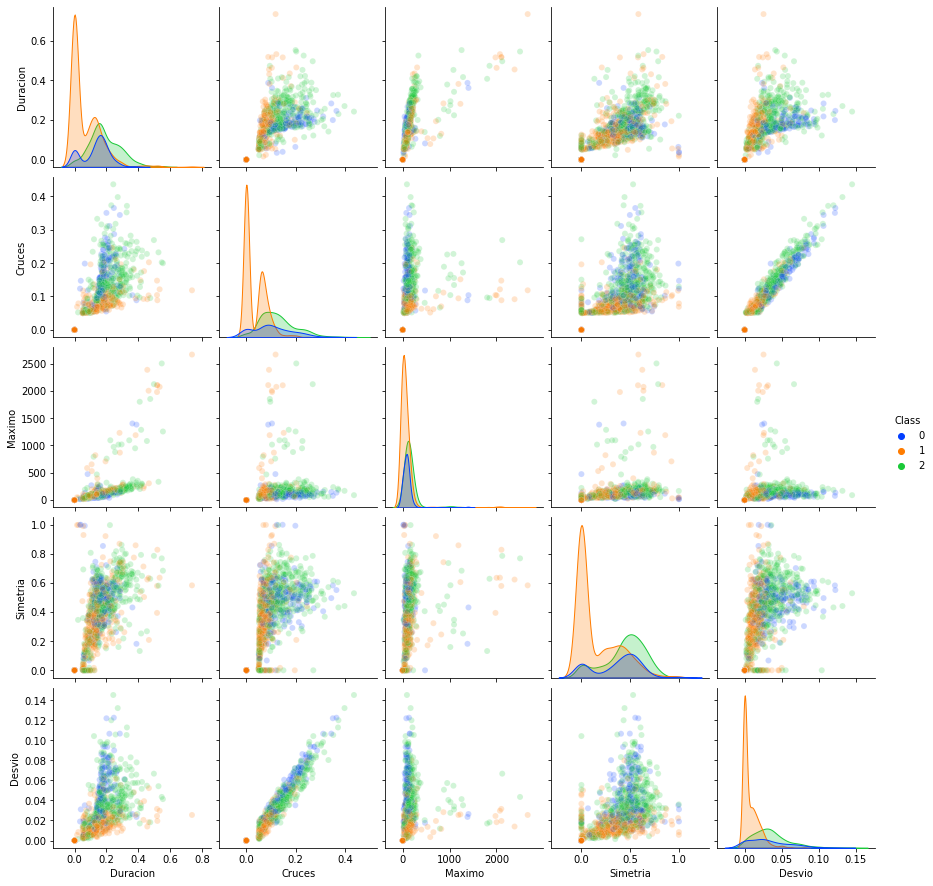

In [52]:
import pandas.testing as tm
import seaborn

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]

labels = [extracted_dataset[i].label for i in range(len(extracted_dataset))]

df = pd.DataFrame(extracted_data, columns=colnames)
df.insert(len(df.columns), "Class", labels)

seaborn.pairplot(df,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright")

### Training

In [53]:
X_data = np.array(extracted_data)
X_data.size
len(extracted_data)

1532

In [55]:
X_data = extracted_data
y_data = [extracted_dataset[i].label for i in range(len(extracted_dataset))]

In [56]:
#X_train = []
#y_train = []

#test_indexes = test_labels.filename.to_list()
#counter = 0
#for i, value in enumerate(extracted_data):
#    if value == []:
#        continue
#    if i not in test_indexes:
#        X_train.append(value)
#        y_train.append(y_data[counter])
#        counter += 1


#### Split dataset

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.33,
                                                    random_state=42)

#### Oversampling

In [60]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 157, 1: 572, 2: 297}

In [61]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler(sampling_strategy='all')
X_train, y_train = oversample.fit_resample(np.array(X_train), np.array(y_train))

In [62]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 572, 1: 572, 2: 572}

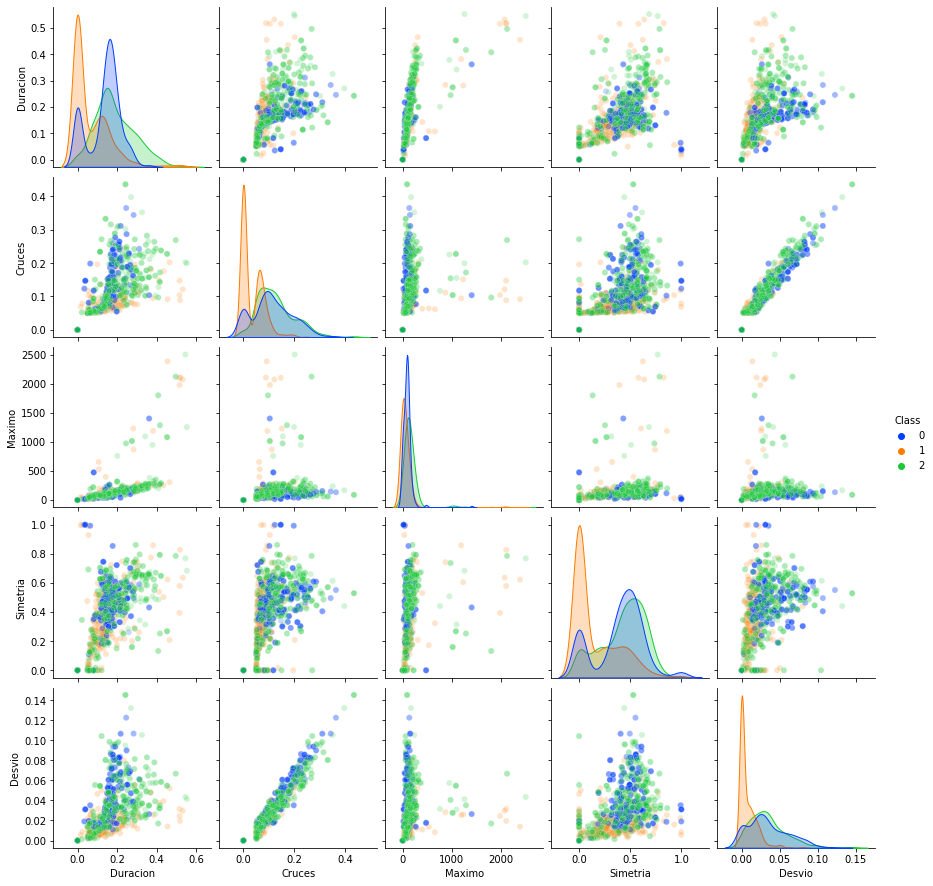

In [65]:
df_train = pd.DataFrame(X_train, columns=colnames)
df_train.insert(len(df_train.columns), "Class", y_train)

seaborn.pairplot(df_train,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright")

#### Grid search and training

In [71]:
models = {}
params = {'criterion': ['gini','entropy'], 'splitter': ['best','random'], 'max_depth': [2, 3, 4]}
model = tu.get_best_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test, params, models, "model_dt") 


{'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}
Grid search time: 0.13838709995616227 s
              precision    recall  f1-score   support

           0    0.30822   0.45918   0.36885        98
           1    0.74510   0.74510   0.74510       255
           2    0.66667   0.45752   0.54264       153

    accuracy                        0.60277       506
   macro avg    0.57333   0.55393   0.55220       506
weighted avg    0.63677   0.60277   0.61101       506

Training time: 0.0022718999534845352 s


#### Results

[Text(0.4351851851851852, 0.9, 'Desvio <= 0.013\ngini = 0.667\nsamples = 1716\nvalue = [572, 572, 572]\nclass = bite'),
 Text(0.16666666666666666, 0.7, 'Duracion <= 0.019\ngini = 0.495\nsamples = 657\nvalue = [113, 441, 103]\nclass = chew'),
 Text(0.07407407407407407, 0.5, 'Cruces <= 0.035\ngini = 0.43\nsamples = 457\nvalue = [108, 327, 22]\nclass = chew'),
 Text(0.037037037037037035, 0.3, 'gini = 0.43\nsamples = 456\nvalue = [108, 326, 22]\nclass = chew'),
 Text(0.1111111111111111, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = chew'),
 Text(0.25925925925925924, 0.5, 'Desvio <= 0.004\ngini = 0.51\nsamples = 200\nvalue = [5, 114, 81]\nclass = chew'),
 Text(0.18518518518518517, 0.3, 'Cruces <= 0.05\ngini = 0.379\nsamples = 26\nvalue = [2, 4, 20]\nclass = chew_byte'),
 Text(0.14814814814814814, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]\nclass = bite'),
 Text(0.2222222222222222, 0.1, 'gini = 0.278\nsamples = 24\nvalue = [0, 4, 20]\nclass = chew_byte'),
 Text(0.3333333333

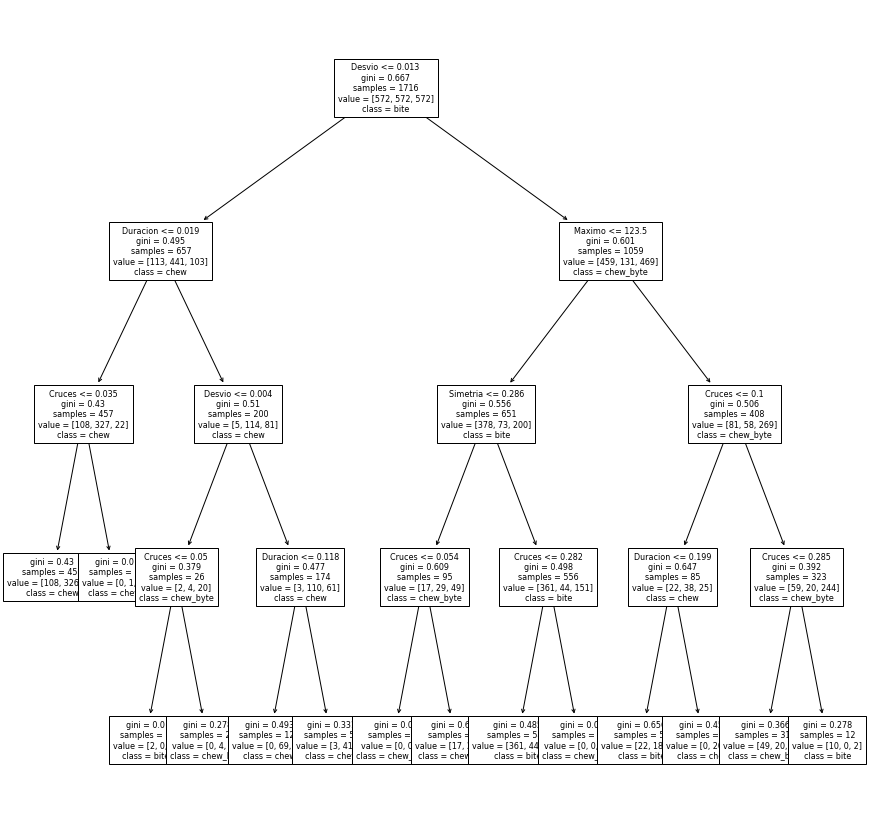

In [84]:
plt.figure(figsize=(15, 15))
tree.plot_tree(model.model, fontsize=8, feature_names=colnames, class_names=list(class_labels.values()))

#plt.savefig('tree.png', format='png', bbox_inches = "tight")